In [1]:
import pandas as pd; pd.set_option('max_rows', 50)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf # 야후 파이낸스
import bt             # 백테스트 라이브러리
import talib          # 보조지표 라이브러리

# 날짜 변수 정의

In [2]:
# 데이터 수집 기간 : rolling, 백테스팅을 위해 여분
start_date_pad = '2003-07-29'
end_date_pad   = '2021-10-29'

# 학습 1기간
start_date_1p_train = '2003-09-29'
end_date_1p_train   = '2011-09-28'

# 학습 2기간
start_date_2p_train = '2003-09-29'
end_date_2p_train   = '2016-09-28'

# 예측 및 백테스트 1기간
start_date_1p  = '2011-09-29'
end_date_1p    = '2016-10-28'
end_date_1p_bt = '2016-09-28'

# 예측 및 백테스트 1기간
start_date_2p  = '2016-09-29'
end_date_2p    = '2021-10-28'
end_date_2p_bt = '2021-09-28'

# 실제-예측 기간 차이
pred_diff = 20

# 주가 데이터 수집

In [3]:
# 지수
indice_tickers = ['^KS11', '^GSPC', '^IXIC',  '^N225',  '^HSI',     '^FCHI', '^GDAXI']
indice_names   = ['kospi', 'sp500', 'nasdaq', 'nikkei', 'hangseng', 'cac',   'dax']

# 지수 추종 ETF   : 코스피,   S&P500,  나스닥,   닛케이,     홍콩,       프랑스,   독일,   미 국채
etf_tickers    = ['EWY',   'SPY',   'QQQ',    'EWJ',    'EWH',      'EWQ',   'EWG', 'AGG']
etf_names      = ['kospi', 'sp500', 'nasdaq', 'nikkei', 'hangseng', 'cac',   'dax', 'agg']

# 지수 OHLCV
indice = yf.download(indice_tickers, start=start_date_pad, end=end_date_pad)
# 지수 추종 OHLCV
etf    = yf.download(etf_tickers, start=start_date_pad, end=end_date_pad)

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  8 of 8 completed


In [4]:
etf['Adj Close']

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
Date,,,,,,,,
2003-07-28,NaN,8.589716,4.700957,24.707081,10.765284,17.662935,27.658077,69.914574
2003-07-29,NaN,8.562789,4.724343,24.390320,10.625311,17.903793,27.449936,69.592468
2003-07-30,NaN,8.475275,4.712651,23.883511,10.695295,17.767307,27.250454,69.424469
2003-07-31,NaN,8.549325,4.765272,24.073557,10.708021,17.422083,27.580019,69.585503
2003-08-01,NaN,8.414692,4.741884,23.788479,10.517148,17.767307,27.285149,68.969383
...,...,...,...,...,...,...,...,...
2021-10-22,113.880913,33.779999,24.680000,68.419998,38.970001,80.360001,374.100006,453.119995
2021-10-25,113.990738,33.810001,24.760000,68.449997,38.639999,81.440002,377.929993,455.549988
2021-10-26,114.200409,33.990002,24.700001,68.459999,38.849998,82.029999,379.119995,455.959991


In [5]:
indice['Adj Close']

,^FCHI,^GDAXI,^GSPC,^HSI,^IXIC,^KS11,^N225
Date,,,,,,,
2003-07-28,3164.929932,3417.770020,996.520020,10134.879883,1735.359985,NaN,NaN
2003-07-29,3142.389893,3428.120117,989.280029,10198.599609,1731.369995,722.330017,9834.309570
2003-07-30,3172.510010,3429.030029,987.489990,10121.219727,1720.910034,714.150024,9632.660156
2003-07-31,3210.270020,3487.860107,990.309998,10134.830078,1735.020020,713.520020,9563.209961
2003-08-01,3169.629883,3438.889893,980.150024,10248.599609,1715.619995,727.260010,9611.669922
...,...,...,...,...,...,...,...
2021-10-22,6733.689941,15542.980469,4544.899902,26126.929688,15090.200195,3006.159912,28804.849609
2021-10-25,6712.870117,15599.230469,4566.479980,26132.029297,15226.709961,3020.540039,28600.410156
2021-10-26,6766.509766,15757.059570,4574.790039,26038.269531,15235.709961,3049.080078,29106.009766


In [6]:
etf['Adj Close']

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
Date,,,,,,,,
2003-07-28,NaN,8.589716,4.700957,24.707081,10.765284,17.662935,27.658077,69.914574
2003-07-29,NaN,8.562789,4.724343,24.390320,10.625311,17.903793,27.449936,69.592468
2003-07-30,NaN,8.475275,4.712651,23.883511,10.695295,17.767307,27.250454,69.424469
2003-07-31,NaN,8.549325,4.765272,24.073557,10.708021,17.422083,27.580019,69.585503
2003-08-01,NaN,8.414692,4.741884,23.788479,10.517148,17.767307,27.285149,68.969383
...,...,...,...,...,...,...,...,...
2021-10-22,113.880913,33.779999,24.680000,68.419998,38.970001,80.360001,374.100006,453.119995
2021-10-25,113.990738,33.810001,24.760000,68.449997,38.639999,81.440002,377.929993,455.549988
2021-10-26,114.200409,33.990002,24.700001,68.459999,38.849998,82.029999,379.119995,455.959991


# 지수와 지수 추종 ETF의 상관관계

In [7]:
pd.concat([indice['Adj Close'], etf['Adj Close']], axis=1).corr().iloc[:7, -7:]

# 코스피 : 0.977490
# sp500 : 0.998325
# 나스닥 : 0.998903
# 닛케이 : 0.976603
# 항셍   : 0.906356
# 프랑스 : 0.883865
# 독일   : 0.952550

,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
^FCHI,0.761684,0.652673,0.891918,0.883865,0.665407,0.657152,0.710768
^GDAXI,0.952550,0.972969,0.902571,0.908758,0.889398,0.886084,0.938418
^GSPC,0.867086,0.918053,0.932788,0.900267,0.838659,0.981866,0.998325
^HSI,0.915971,0.906356,0.755839,0.851663,0.890112,0.661726,0.724927
^IXIC,0.821541,0.884684,0.900776,0.861896,0.822208,0.998903,0.991702
^KS11,0.921939,0.913960,0.783142,0.849054,0.977490,0.796176,0.821399
^N225,0.841868,0.831728,0.976603,0.906331,0.760570,0.875070,0.913039


# 글라이드 패스 함수

In [8]:
def makeGlidePath(etf_ohlcv, glide_weight, risk_weight, start_year=2011):
    
    # 날짜, 위험자산 비중 데이터프레임
    df = pd.DataFrame(
        {
            'Date': [str(year) + '-09-29' for year in range(start_year, 2022)], 
            'RA'  : glide_weight
        }
    )
    
    # 장이 열린 날짜로 조정
    df['Date'] = df.apply(lambda x: etf_ohlcv['Adj Close'].index[etf_ohlcv['Adj Close'].index.get_loc(x['Date'], method='nearest')], axis=1)
    
    # 비위험자산 비중
    df['AGG'] = 1 - df['RA']
    
    # 위험자산 비중
    risk_etfs = ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
    for risk_etf, weight in zip(risk_etfs, risk_weight):
        df[risk_etf] = df['RA'] * weight
    
    df.set_index('Date', inplace=True)
    df.drop('RA', axis=1, inplace=True)
    
    return df

# baseline 변동성 데이터

In [9]:
# 위험자산내 비중 [독일,   홍콩,  일본,   프랑스, 한국,   S&P,   나스닥]
risk_weight   = [.0250, .0250, .0375, .0375, .2500, .2000, .4250]

# 베이스라인 변동성 데이터의 글라이드 패스
gw_baseline = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
gp_baseline = makeGlidePath(etf, gw_baseline, risk_weight, start_year=int(start_date_1p_train[:4]))
gp_baseline

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
Date,,,,,,,,
2003-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2004-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2005-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2006-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2007-09-28,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2008-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2009-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2010-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2011-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425


In [10]:
# 백테스팅의 데이터
baseline_data = etf['Adj Close'].loc[start_date_pad:]

# 백테스팅 전략
baseline_strategy = bt.Strategy(
    'baseline', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_baseline), 
        bt.algos.Rebalance(), 
    ]
)

# 백테스트
baseline_backtest = bt.Backtest(strategy=baseline_strategy, data=baseline_data)
train_result   = bt.run(baseline_backtest)

In [12]:
train_hv = train_result.prices
train_hv['HV'] = train_hv['baseline'].pct_change().rolling(window=20, min_periods=0, center=False).std() * np.sqrt(252)
train_hv = train_hv['2003-09-29':]
train_hv['HV_pred'] = train_hv['HV'].shift(-pred_diff)
train_hv['HV_resid'] = train_hv['HV'].diff(-pred_diff)

train_hv

C:\Users\674\AppData\Local\Temp/ipykernel_20504/2931599053.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_hv['HV_pred'] = train_hv['HV'].shift(-pred_diff)
C:\Users\674\AppData\Local\Temp/ipykernel_20504/2931599053.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_hv['HV_resid'] = train_hv['HV'].diff(-pred_diff)


,baseline,HV,HV_pred,HV_resid
2003-09-29,100.000000,0.000000,0.188982,-0.188982
2003-09-30,98.666207,0.047345,0.188545,-0.141200
2003-10-01,101.496213,0.114520,0.164045,-0.049525
2003-10-02,102.256309,0.116915,0.163174,-0.046259
2003-10-03,104.068612,0.130729,0.153917,-0.023187
...,...,...,...,...
2021-10-22,671.965993,0.144376,NaN,NaN
2021-10-25,676.977990,0.146571,NaN,NaN
2021-10-26,679.063837,0.118043,NaN,NaN
2021-10-27,675.510110,0.119852,NaN,NaN


In [13]:
train_hv.loc[:'2011-09-29', 'HV_resid'].mean()

-0.002013433927766569

In [14]:
train_hv.loc[:'2011-09-29', 'HV_resid'].std()

0.10171964667304818

In [15]:
train_result.get_security_weights()['2003-09-29':]

,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
2003-09-29,0.024993,0.024997,0.037495,0.037492,0.249992,0.199988,0.424971
2003-09-30,0.024951,0.025282,0.037488,0.037756,0.249630,0.198288,0.426534
2003-10-01,0.025170,0.025303,0.037940,0.037585,0.253354,0.197100,0.423477
2003-10-02,0.024500,0.025811,0.038402,0.036986,0.256096,0.196284,0.421853
2003-10-03,0.024662,0.025766,0.038423,0.037223,0.257290,0.198258,0.418310
...,...,...,...,...,...,...,...
2021-10-22,0.024758,0.025104,0.035128,0.037818,0.243903,0.202369,0.430823
2021-10-25,0.024597,0.024999,0.034883,0.037220,0.245350,0.202928,0.429927
2021-10-26,0.024652,0.024861,0.034781,0.037307,0.246369,0.202941,0.428992
2021-10-27,0.024672,0.024770,0.034709,0.037407,0.244525,0.204483,0.429338


# 보조지표

## 사전정의함수

In [16]:
def getPsy(x):
    """심리도 사전 정의 함수"""
    if x > 0:
        result = 1
    else:
        result = np.nan
    return result

def getRevPlus(a):
    if a > 0:
        result = a
    else:
        result = 0
    return result

def getRevMinus(a):
    if a < 0:
        result = a
    else:
        result = 0
    return result

def getVRplus(a, b):
    if a > 0:
        result = b
    else:
        result = 0
    return result

def getVRminus(a, b):
    if a < 0:
        result = b
    else:
        result = 0
    return result

## 보조지표 함수

In [17]:
def getIndicators(df):
    
    # Change : 변동률
    df['Change'] = df['Adj Close'].pct_change()
    
    # Moving Average : 주가이동평균
    df['MA5'] = talib.MA(df['Adj Close'], timeperiod=5)
    df['MA20'] = talib.MA(df['Adj Close'], timeperiod=20)
    df['MA60'] = talib.MA(df['Adj Close'], timeperiod=60)
    df['MA120'] = talib.MA(df['Adj Close'], timeperiod=120)
    # 가격이동평균 기울기 : (당일 이동평균 - 전날 이동평균) / 전날 이동평균
    df['MA5_gra'] = (df['MA5'] - df['MA5'].shift(1)) / df['MA5'].shift(1)
    df['MA20_gra'] = (df['MA20'] - df['MA20'].shift(1)) / df['MA20'].shift(1)
    df['MA60_gra'] = (df['MA60'] - df['MA60'].shift(1)) / df['MA60'].shift(1)
    df['MA120_gra'] = (df['MA120'] - df['MA120'].shift(1)) / df['MA120'].shift(1)    
    
    # 거래량이동평균
    df['V_MA5'] = talib.MA(df['Volume'], timeperiod=5)
    df['V_MA20'] = talib.MA(df['Volume'], timeperiod=20)
    df['V_MA60'] = talib.MA(df['Volume'], timeperiod=60)
    df['V_MA120'] = talib.MA(df['Volume'], timeperiod=120)
    
    # 지수이동평균
    df['EMA5'] = talib.EMA(df['Adj Close'], timeperiod=5)
    df['EMA20'] = talib.EMA(df['Adj Close'], timeperiod=20)
    df['EMA60'] = talib.EMA(df['Adj Close'], timeperiod=60)
    df['EMA120'] = talib.EMA(df['Adj Close'], timeperiod=120)   
    
    # MACD
    macd, macdsignal, macdhist = talib.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACD_sig9'] = macdsignal
    df['MACD_OSC'] = macdhist
    
    # Stochastic
    fastk, fastd = talib.STOCHF(df['High'], df['Low'], df['Adj Close'], fastk_period=14, fastd_period=3)
    slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=14, slowk_period=5, slowd_period=3)
    df['Fast%K'] = fastk
    df['Fast%D'] = fastd
    df['Slow%K'] = slowk
    df['Slow%D'] = slowd
    
    # RSI: 9일, 14일, 15일, 25일, 28일 (RSI_sig 9일)
    df_index = df.index.astype('str')
    U = np.where(df['Adj Close'].diff(1) > 0, df['Adj Close'].diff(1), 0)
    D = np.where(df['Adj Close'].diff(1) < 0, df['Adj Close'].diff(1)*(-1), 0)
    AU = pd.DataFrame(U, index = df_index).rolling(window=14).mean() # RSI: 14일
    AD = pd.DataFrame(D, index = df_index).rolling(window=14).mean()
    RSI = AU / (AD+AU) * 100
    
    df.insert(len(df.columns), "RSI14", RSI)
    df.insert(len(df.columns), "RSI signal", df['RSI14'].ewm(span=9).mean())
    
    # CCI (14일 기준)
    M = (df['High']+df['Low']+df['Adj Close'])/3
    m = M.rolling(window=14).mean()
    d = abs(M-m).rolling(window=14).mean()
    df['CCI'] =( M - m )/(d*0.015)
    df['CCI'] = np.where(df['CCI'] > 0, df['CCI'] + 0.5, df['CCI'] - 0.5)
    
    # A ratio
    df['A'] = (df['High'] - df['Open']).rolling(window=20).sum() / (df['Open'] - df['Low']).rolling(window=20).sum()
    df['A_Ratio'] = df['A']*100
    
    # B ratio
    df['B'] = (df['High'] - df['Adj Close'].shift(1)).rolling(window=20).sum() / (df['Adj Close'].shift(1) - df['Low']).rolling(window=20).sum()
    df['B_Ratio'] = df['B']*100
    
    
    df.drop(['A', 'B'], axis=1, inplace=True)
    
    # ATR(14일 기준)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # DMI
    df['UpDI'] = talib.PLUS_DI(df['High'], df['Low'],  df['Adj Close'], timeperiod=14)
    df['DownDI'] = talib.MINUS_DI(df['High'], df['Low'],  df['Adj Close'], timeperiod=14)
    
    # MFI
    df['MFI'] = talib.MFI(df['High'], df['Low'], df['Adj Close'], df['Volume'], timeperiod=14)
    
    # Momentum
    df['Momentum'] = talib.MOM(df['Adj Close'], timeperiod=12)
    
    # Sonar
    df['EMA9'] = talib.EMA(df['Adj Close'], timeperiod=9)
    df['n_shift_ema'] = df['EMA9'].shift(9)
    df['Sonar'] = df['EMA9'] - df['n_shift_ema']
    df['Sonar_sig5'] = talib.EMA(df['Sonar'], timeperiod=5)
    
    df.drop('EMA9', axis=1, inplace= True)
    
    df.drop('n_shift_ema', axis=1, inplace=True)
    
    # STDEV(20일 표준편차)
    df['STDEV'] = talib.STDDEV(df['Adj Close'], timeperiod=20)
    
    # Sigma(20일) (20일짜리 표준편차 사용)
    df['Sigma'] = ( df['Adj Close'] - df['Adj Close'].rolling(window=20).mean() ) / df['STDEV']
    
    # TRIX(12일) (퍼센트)
    df['TRIX'] = talib.TRIX(df['Adj Close'], timeperiod=12)
    
    # VR : 주가 상승일 거래량 / 주가 하락일 거래량 * 100, 
    df['VRplus']  = df.apply(lambda x: getVRplus(x['Change'], x['Volume']), axis=1)
    df['VRminus'] = df.apply(lambda x: getVRminus(x['Change'], x['Volume']), axis=1)
    
    df['VRplus_rolling']  = df['VRplus'].rolling(window=20).sum() # period: 20
    df['VRminus_rolling'] = df['VRminus'].rolling(window=20).sum()
    
    df['VR'] = df['VRplus_rolling'] / df['VRminus_rolling'] * 100
    
    df.drop(['VRplus', 'VRminus', 'VRplus_rolling', 'VRminus_rolling'], axis=1, inplace=True)
    
    # William's %R (14일)
    df['WILLR'] = talib.WILLR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # 심리도
    df['psy_temp'] = df.apply(lambda x: getPsy(x['Change']), axis=1)
    df['Psy']      = df['psy_temp'].rolling(window=10).count() / 10 * 100
    df.drop('psy_temp', axis=1, inplace=True)
    
    # 이격도
    df['Disparity20'] = (df['Adj Close'] / df['Adj Close'].rolling(window=20).mean()) * 100
    df['Disparity60'] = (df['Adj Close'] / df['Adj Close'].rolling(window=60).mean()) * 100
    
    # ADX
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # Chaikin's OSC
    df['ADOSC'] = talib.ADOSC(df['High'], df['Low'], df['Adj Close'], df['Volume'], fastperiod=3, slowperiod=10)
    
    # 거래량 OSC(10일, 20일, 9일)
    df['Volume_OSC'] = (df['Volume'].rolling(window=10).mean() - df['Volume'].rolling(window=20).mean()) / df['Volume'].rolling(window=10).mean() * 100
    
    # 볼린저 밴드
    df['upperband'], df['middleband'], df['lowerband'] = talib.BBANDS(df['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    
    
    return df

In [18]:
etfs = []
# ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
for i, j in zip(etf['Adj Close'].columns[1:], risk_weight):
    temp_etf = getIndicators(etf.swaplevel(axis=1)[i])['2003-09-29':]
    temp_etf.fillna(0, inplace=True)
    temp_etf = temp_etf.loc[:, 'MA5':] * j
    etfs.append(temp_etf)

f:\workspace\venv\lib\site-packages\pandas\core\window\rolling.py:1606: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  warnings.warn(
f:\workspace\venv\lib\site-packages\pandas\core\window\rolling.py:1606: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  warnings.warn(
f:\workspace\venv\lib\site-packages\pandas\core\window\rolling.py:1606: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  warnings.warn(
f:\workspace\venv\lib\site-packages\pandas\core\window\rolling.py:1606: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  warnings.warn(
f:\workspace\venv\lib\site-packages\pandas\core\

In [19]:
sum(etfs)

,MA5,MA20,MA60,MA120,MA5_gra,MA20_gra,MA60_gra,MA120_gra,V_MA5,V_MA20,...,WILLR,Psy,Disparity20,Disparity60,ADX,ADOSC,Volume_OSC,upperband,middleband,lowerband
Date,,,,,,,,,,,,,,,,,,,,,
2003-09-29,42.146221,42.842341,0.000000,0.000000,-0.003142,-0.000810,0.000000,0.000000,3.822771e+07,3.386586e+07,...,-472.336803,38.250,97.591740,0.000000,18.762568,-3.909975e+09,0.484744,44.066588,42.842341,41.618095
2003-09-30,41.847142,42.769253,0.000000,0.000000,-0.007730,-0.002238,0.000000,0.000000,4.313977e+07,3.470818e+07,...,-450.208372,28.250,96.506025,0.000000,19.247360,-4.059619e+09,4.466314,44.108395,42.769253,41.430110
2003-10-01,41.927374,42.740050,0.000000,0.000000,0.002179,-0.000942,0.000000,0.000000,4.484279e+07,3.536592e+07,...,-424.533919,37.875,99.353205,0.000000,18.627031,-4.085364e+09,8.823151,44.074613,42.740050,41.405488
2003-10-02,42.126831,42.717888,0.000000,0.000000,0.005389,-0.000766,0.000000,0.000000,4.280619e+07,3.591528e+07,...,-415.254088,40.125,100.166142,0.000000,17.712021,-4.208542e+09,8.880720,44.038388,42.717888,41.397388
2003-10-03,42.477223,42.737590,0.000000,0.000000,0.009944,0.000424,0.000000,0.000000,4.357655e+07,3.650078e+07,...,-395.685196,49.500,101.891171,0.000000,17.789960,-4.319473e+09,9.854309,44.081501,42.737590,41.393680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22,292.397251,285.123539,288.324659,282.587166,0.001954,0.000091,-0.000233,0.000313,2.956807e+07,4.547732e+07,...,-11.522496,61.750,102.241485,100.217535,21.733995,4.102616e+07,-24.072622,295.681766,285.123539,274.565311
2021-10-25,293.412275,285.447644,288.470878,282.801560,0.003393,0.000525,0.000042,0.000361,2.807088e+07,4.503101e+07,...,-4.367299,71.000,102.950515,100.954263,21.396078,4.306214e+07,-24.804775,296.701135,285.447644,274.194154
2021-10-26,294.056998,286.125394,288.632518,283.001050,0.002027,0.001839,0.000098,0.000298,2.953600e+07,4.291163e+07,...,-11.088321,80.125,103.079400,101.251089,21.534014,3.273070e+07,-22.229806,298.022674,286.125394,274.228114


In [20]:
train_multivar = train_hv.merge(sum(etfs), how='left', left_index=True, right_index=True)

In [21]:
train_multivar

,baseline,HV,HV_pred,HV_resid,MA5,MA20,MA60,MA120,MA5_gra,MA20_gra,...,WILLR,Psy,Disparity20,Disparity60,ADX,ADOSC,Volume_OSC,upperband,middleband,lowerband
2003-09-29,100.000000,0.000000,0.188982,-0.188982,42.146221,42.842341,0.000000,0.000000,-0.003142,-0.000810,...,-472.336803,38.250,97.591740,0.000000,18.762568,-3.909975e+09,0.484744,44.066588,42.842341,41.618095
2003-09-30,98.666207,0.047345,0.188545,-0.141200,41.847142,42.769253,0.000000,0.000000,-0.007730,-0.002238,...,-450.208372,28.250,96.506025,0.000000,19.247360,-4.059619e+09,4.466314,44.108395,42.769253,41.430110
2003-10-01,101.496213,0.114520,0.164045,-0.049525,41.927374,42.740050,0.000000,0.000000,0.002179,-0.000942,...,-424.533919,37.875,99.353205,0.000000,18.627031,-4.085364e+09,8.823151,44.074613,42.740050,41.405488
2003-10-02,102.256309,0.116915,0.163174,-0.046259,42.126831,42.717888,0.000000,0.000000,0.005389,-0.000766,...,-415.254088,40.125,100.166142,0.000000,17.712021,-4.208542e+09,8.880720,44.038388,42.717888,41.397388
2003-10-03,104.068612,0.130729,0.153917,-0.023187,42.477223,42.737590,0.000000,0.000000,0.009944,0.000424,...,-395.685196,49.500,101.891171,0.000000,17.789960,-4.319473e+09,9.854309,44.081501,42.737590,41.393680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22,671.965993,0.144376,NaN,NaN,292.397251,285.123539,288.324659,282.587166,0.001954,0.000091,...,-11.522496,61.750,102.241485,100.217535,21.733995,4.102616e+07,-24.072622,295.681766,285.123539,274.565311
2021-10-25,676.977990,0.146571,NaN,NaN,293.412275,285.447644,288.470878,282.801560,0.003393,0.000525,...,-4.367299,71.000,102.950515,100.954263,21.396078,4.306214e+07,-24.804775,296.701135,285.447644,274.194154
2021-10-26,679.063837,0.118043,NaN,NaN,294.056998,286.125394,288.632518,283.001050,0.002027,0.001839,...,-11.088321,80.125,103.079400,101.251089,21.534014,3.273070e+07,-22.229806,298.022674,286.125394,274.228114
2021-10-27,675.510110,0.119852,NaN,NaN,294.395797,286.756531,288.739293,283.173996,0.000865,0.001683,...,-20.157023,72.500,102.361845,100.736228,21.302388,1.402957e+07,-21.642026,299.017421,286.756531,274.495642


In [22]:
# train_multivar.to_csv('./train_multivar.csv')

# 변동성과 기사 표제어 상관관계

In [23]:
date_dtm = pd.read_csv('../nlp/date_dtm.csv')
date_dtm['date'] = pd.to_datetime(date_dtm['date'])
date_dtm['sum'] = date_dtm[['긴급','탈환','구제','변동성','추락','위기','서브프라임','인플레','호전','과대','패닉','관심','금융위기','변동','코로나','폭락','위기']].sum(axis=1)

In [24]:
date_dtm

,date,index,page,통화,최고,고용,총선,관건,급등,긴장,...,하향,정상,후퇴,공시,반락,활성화,긍정,개혁,리치,sum
0,2000-03-17,0,3163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2000-03-18,6,9489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2000-03-20,49,22141,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000-03-21,23,6326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2000-03-22,58,11360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7802,2021-11-06,22615529,63,0.0,8.0,9.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
7803,2021-11-07,29164261,77,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
7804,2021-11-08,123826040,667,0.0,3.0,2.0,0.0,0.0,6.0,1.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
7805,2021-11-09,125060565,603,1.0,9.0,0.0,0.0,0.0,6.0,0.0,...,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,17.0


In [25]:
temp = train_hv.merge(date_dtm[['date', 'sum']], how='left', left_on=train_hv.index, right_on='date')

In [26]:
temp

,baseline,HV,HV_pred,HV_resid,date,sum
0,100.000000,0.000000,0.188982,-0.188982,2003-09-29,0.0
1,98.666207,0.047345,0.188545,-0.141200,2003-09-30,0.0
2,101.496213,0.114520,0.164045,-0.049525,2003-10-01,0.0
3,102.256309,0.116915,0.163174,-0.046259,2003-10-02,0.0
4,104.068612,0.130729,0.153917,-0.023187,2003-10-03,0.0
...,...,...,...,...,...,...
4549,671.965993,0.144376,NaN,NaN,2021-10-22,17.0
4550,676.977990,0.146571,NaN,NaN,2021-10-25,25.0
4551,679.063837,0.118043,NaN,NaN,2021-10-26,13.0
4552,675.510110,0.119852,NaN,NaN,2021-10-27,10.0


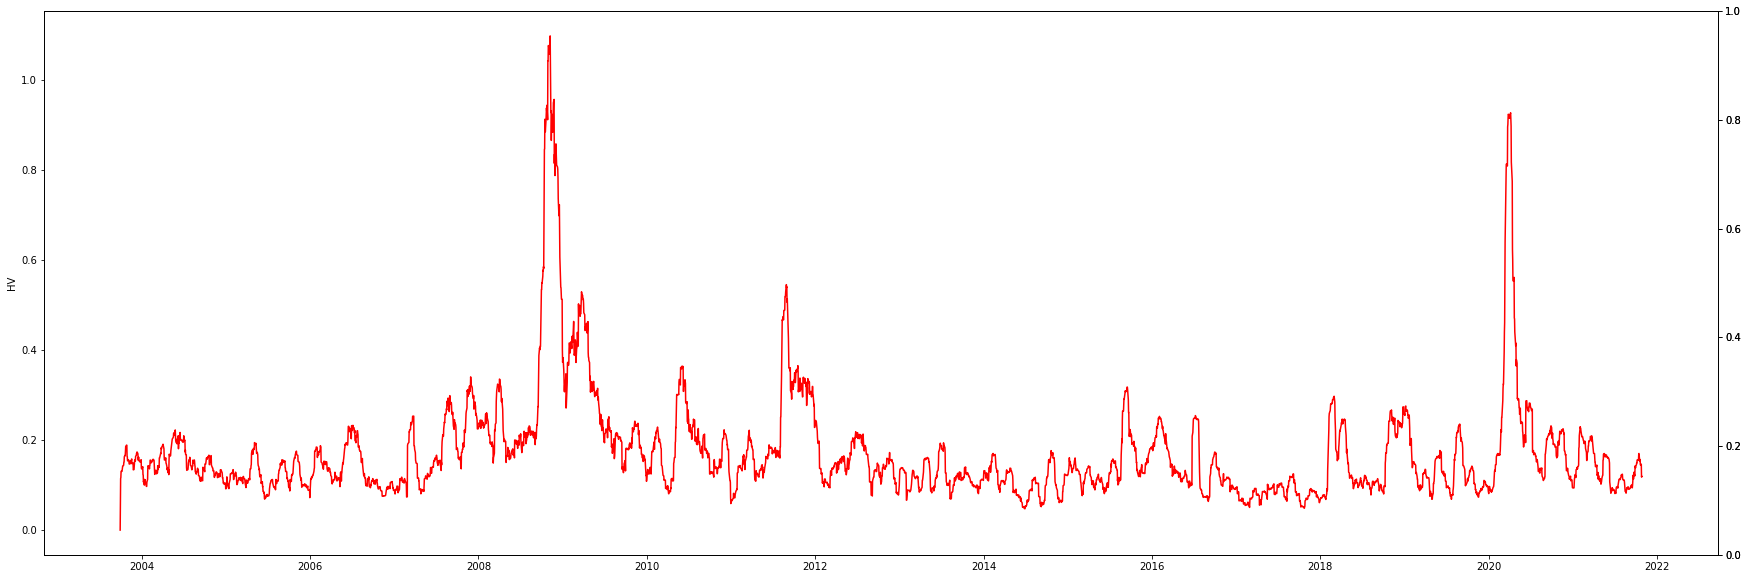

In [27]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(30, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

sns.lineplot(x=train_hv.index, y=temp['HV'], ax=ax1, color='red')
# sns.lineplot(x=train_hv.index, y=temp['train_portfolio'], ax=ax2)
# sns.lineplot(x=temp.index, y=temp['sum'], ax=ax3, color='green')
plt.show()

# 벤치마크 글라이드 패스 & 백테스트 포트폴리오

## 공격형

In [28]:
# 공격형 글라이드 패스 벤치마크
glide_weight_att = [1.000, 1.000, 1.000, 1.000, .9530, .8820, .8310, .7470, .6780, .6110, .5460]
gp_bench_att = makeGlidePath(etf, glide_weight_att, risk_weight, start_year=2011)
gp_bench_att

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
Date,,,,,,,,
2011-09-29,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2012-09-28,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2013-09-30,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2014-09-29,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2015-09-29,0.047,0.023825,0.023825,0.035737,0.035737,0.23825,0.1906,0.405025
2016-09-29,0.118,0.022050,0.022050,0.033075,0.033075,0.22050,0.1764,0.374850
2017-09-29,0.169,0.020775,0.020775,0.031162,0.031162,0.20775,0.1662,0.353175
2018-09-28,0.253,0.018675,0.018675,0.028012,0.028012,0.18675,0.1494,0.317475
2019-09-30,0.322,0.016950,0.016950,0.025425,0.025425,0.16950,0.1356,0.288150


In [29]:
data = etf['Adj Close'].loc['2011-07-29':]

bench_att = bt.Strategy(
    'portfolio', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_att), 
        bt.algos.Rebalance(), 
    ]
)
bench_att_backtest = bt.Backtest(strategy=bench_att, data=data)
bench_att_result   = bt.run(bench_att_backtest)

bench_att_hv = bench_att_result.prices
bench_att_hv['HV'] = bench_att_hv['portfolio'].pct_change().rolling(window=20, min_periods=0, center=False).std() * np.sqrt(252)
bench_att_hv['HV_pred'] = bench_att_hv['HV'].shift(-pred_diff)
bench_att_hv['HV_resid'] = bench_att_hv['HV'].diff(-pred_diff)
bench_att_hv = bench_att_hv['2011-09-29':'2021-09-29']
bench_att_hv

,portfolio,HV,HV_pred,HV_resid
2011-09-29,100.000000,0.000000,0.338044,-0.338044
2011-09-30,96.894452,0.110236,0.310554,-0.200318
2011-10-03,94.167319,0.144824,0.312931,-0.168107
2011-10-04,96.395740,0.172882,0.326629,-0.153747
2011-10-05,98.063515,0.185675,0.326261,-0.140586
...,...,...,...,...
2021-09-23,335.484593,0.084662,0.089858,-0.005196
2021-09-24,334.226522,0.083768,0.089071,-0.005303
2021-09-27,333.807661,0.078138,0.090623,-0.012484
2021-09-28,328.225329,0.096012,0.065917,0.030094


<AxesSubplot:ylabel='HV_resid'>

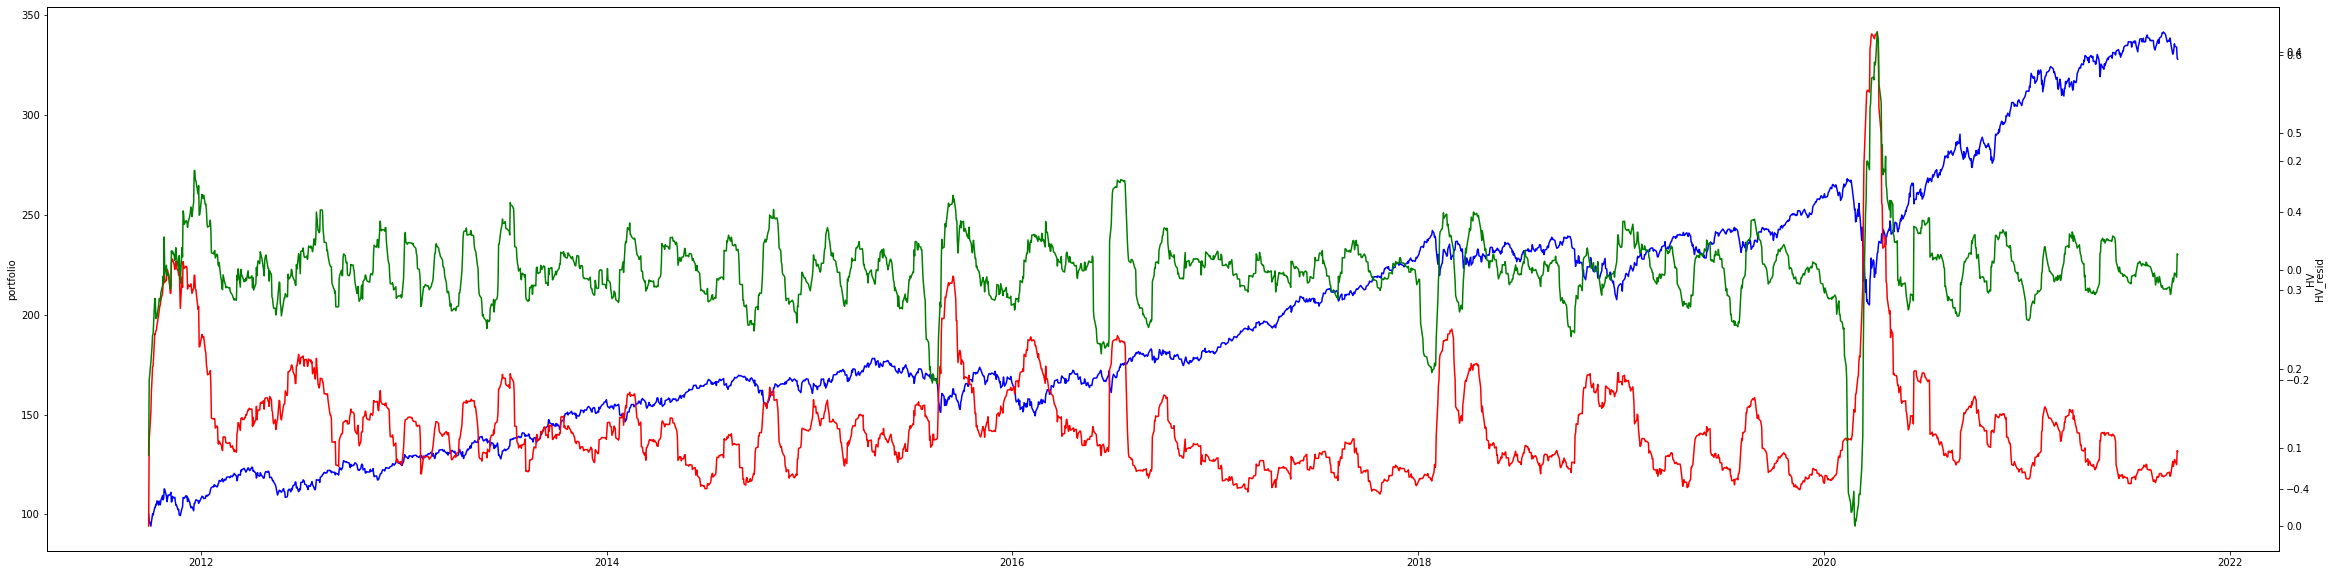

In [30]:
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

sns.lineplot(ax=ax1, color='b', y=bench_att_hv['portfolio'], x=bench_att_hv.index)
sns.lineplot(ax=ax2, color='r', y=bench_att_hv['HV'], x=bench_att_hv.index)
sns.lineplot(ax=ax3, color='g', y=bench_att_hv['HV_resid'], x=bench_att_hv.index)

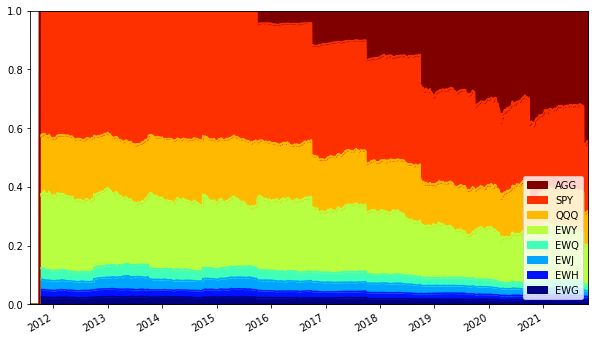

In [31]:
from matplotlib import cm

ax = bench_att_result.get_security_weights().plot.area(figsize = (10, 6), ylim = [0, 1], legend = False, colormap = cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')
plt.show()

## 중립형

In [32]:
# 중립형 글라이드 패스 벤치마크
glide_weight_neu = [.7600, .7600, .7650, .7100, .6850, .6600, .6380, .6160, .5940, .5720, .5500]
gp_bench_neu = makeGlidePath(etf, glide_weight_neu, risk_weight, start_year=2011)
gp_bench_neu

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
Date,,,,,,,,
2011-09-29,0.240,0.019000,0.019000,0.028500,0.028500,0.19000,0.1520,0.323000
2012-09-28,0.240,0.019000,0.019000,0.028500,0.028500,0.19000,0.1520,0.323000
2013-09-30,0.235,0.019125,0.019125,0.028687,0.028687,0.19125,0.1530,0.325125
2014-09-29,0.290,0.017750,0.017750,0.026625,0.026625,0.17750,0.1420,0.301750
2015-09-29,0.315,0.017125,0.017125,0.025688,0.025688,0.17125,0.1370,0.291125
2016-09-29,0.340,0.016500,0.016500,0.024750,0.024750,0.16500,0.1320,0.280500
2017-09-29,0.362,0.015950,0.015950,0.023925,0.023925,0.15950,0.1276,0.271150
2018-09-28,0.384,0.015400,0.015400,0.023100,0.023100,0.15400,0.1232,0.261800
2019-09-30,0.406,0.014850,0.014850,0.022275,0.022275,0.14850,0.1188,0.252450


In [33]:
data = etf['Adj Close'].loc['2011-07-29':]

bench_neu = bt.Strategy(
    'portfolio', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_neu), 
        bt.algos.Rebalance(), 
    ]
)
bench_neu_backtest = bt.Backtest(strategy=bench_neu, data=data)
bench_neu_result   = bt.run(bench_neu_backtest)

bench_neu_hv = bench_neu_result.prices
bench_neu_hv['HV'] = bench_neu_hv['portfolio'].pct_change().rolling(window=20, min_periods=0, center=False).std() * np.sqrt(252)
bench_neu_hv['HV_resid'] = bench_neu_hv['HV'].diff(-pred_diff)
bench_neu_hv = bench_neu_hv['2011-09-29':'2021-09-29']
bench_neu_hv

,portfolio,HV,HV_resid
2011-09-29,100.000000,0.000000,-0.249978
2011-09-30,97.729401,0.080598,-0.149031
2011-10-03,95.755112,0.105023,-0.127578
2011-10-04,97.374268,0.124879,-0.118143
2011-10-05,98.560752,0.133737,-0.109533
...,...,...,...
2021-09-23,283.532449,0.079845,-0.008675
2021-09-24,282.499861,0.079052,-0.008693
2021-09-27,282.143934,0.073489,-0.015807
2021-09-28,277.616170,0.090885,0.024600


<AxesSubplot:ylabel='HV_resid'>

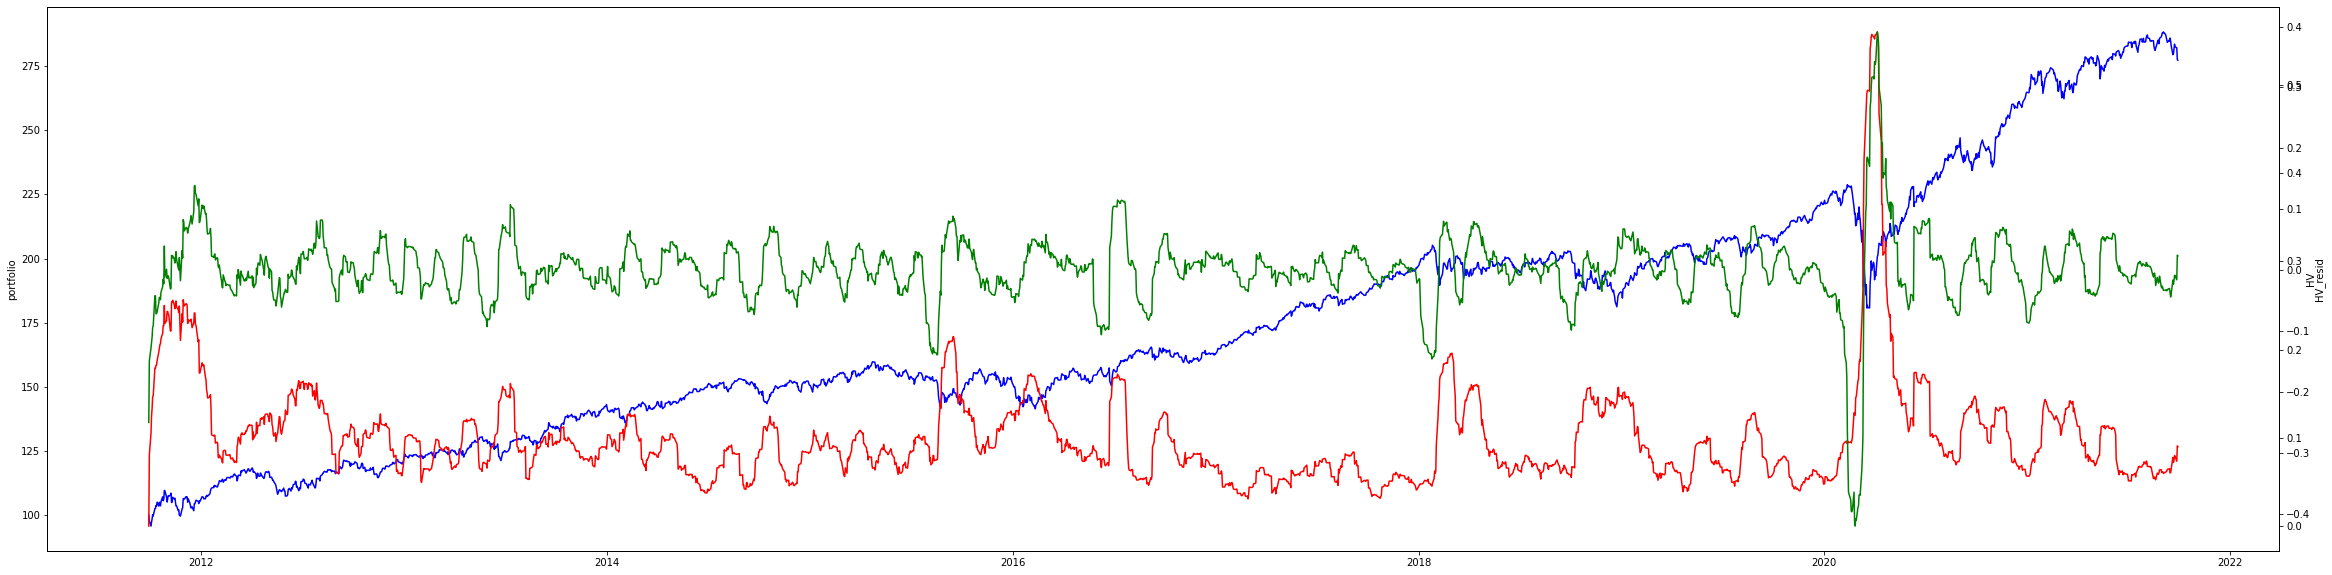

In [34]:
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

sns.lineplot(ax=ax1, color='b', y=bench_neu_hv['portfolio'], x=bench_neu_hv.index)
sns.lineplot(ax=ax2, color='r', y=bench_neu_hv['HV'], x=bench_neu_hv.index)
sns.lineplot(ax=ax3, color='g', y=bench_neu_hv['HV_resid'], x=bench_neu_hv.index)

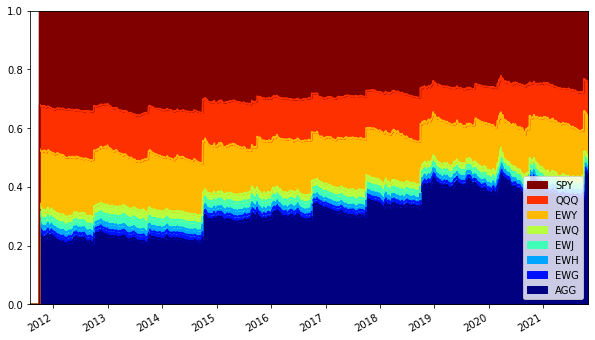

In [35]:
ax = bench_neu_result.get_security_weights().plot.area(figsize = (10, 6), ylim = [0, 1], legend = False, colormap = cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')
plt.show()

## 방어형

In [36]:
# 방어형 글라이드 패스 벤치마크
glide_weight_def = [.7100, .7100, .6700, .6270, .5830, .5370, .4850, .4330, .3930, .3660, .3480]
gp_bench_def = makeGlidePath(etf, glide_weight_def, risk_weight, start_year=2011)
gp_bench_def

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
Date,,,,,,,,
2011-09-29,0.290,0.017750,0.017750,0.026625,0.026625,0.17750,0.1420,0.301750
2012-09-28,0.290,0.017750,0.017750,0.026625,0.026625,0.17750,0.1420,0.301750
2013-09-30,0.330,0.016750,0.016750,0.025125,0.025125,0.16750,0.1340,0.284750
2014-09-29,0.373,0.015675,0.015675,0.023512,0.023512,0.15675,0.1254,0.266475
2015-09-29,0.417,0.014575,0.014575,0.021862,0.021862,0.14575,0.1166,0.247775
2016-09-29,0.463,0.013425,0.013425,0.020137,0.020137,0.13425,0.1074,0.228225
2017-09-29,0.515,0.012125,0.012125,0.018187,0.018187,0.12125,0.0970,0.206125
2018-09-28,0.567,0.010825,0.010825,0.016237,0.016237,0.10825,0.0866,0.184025
2019-09-30,0.607,0.009825,0.009825,0.014738,0.014738,0.09825,0.0786,0.167025


In [37]:
data = etf['Adj Close'].loc['2011-07-29':]

bench_def = bt.Strategy(
    'portfolio', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_def), 
        bt.algos.Rebalance(), 
    ]
)
bench_def_backtest = bt.Backtest(strategy=bench_def, data=data)
bench_def_result   = bt.run(bench_def_backtest)

bench_def_hv = bench_def_result.prices
bench_def_hv['HV'] = bench_def_hv['portfolio'].pct_change().rolling(window=20, min_periods=0, center=False).std() * np.sqrt(252)
bench_def_hv['HV_resid'] = bench_def_hv['HV'].diff(-pred_diff)
bench_def_hv = bench_def_hv['2011-09-29':'2021-09-29']
bench_def_hv

,portfolio,HV,HV_resid
2011-09-29,100.000000,0.000000,-0.231495
2011-09-30,97.903691,0.074412,-0.138218
2011-10-03,96.086570,0.096755,-0.118862
2011-10-04,97.578537,0.114949,-0.110356
2011-10-05,98.664533,0.122997,-0.102668
...,...,...,...
2021-09-23,247.991952,0.053736,-0.009602
2021-09-24,247.240793,0.053567,-0.009296
2021-09-27,246.919175,0.048327,-0.015730
2021-09-28,243.898023,0.062982,0.017112


<AxesSubplot:ylabel='HV_resid'>

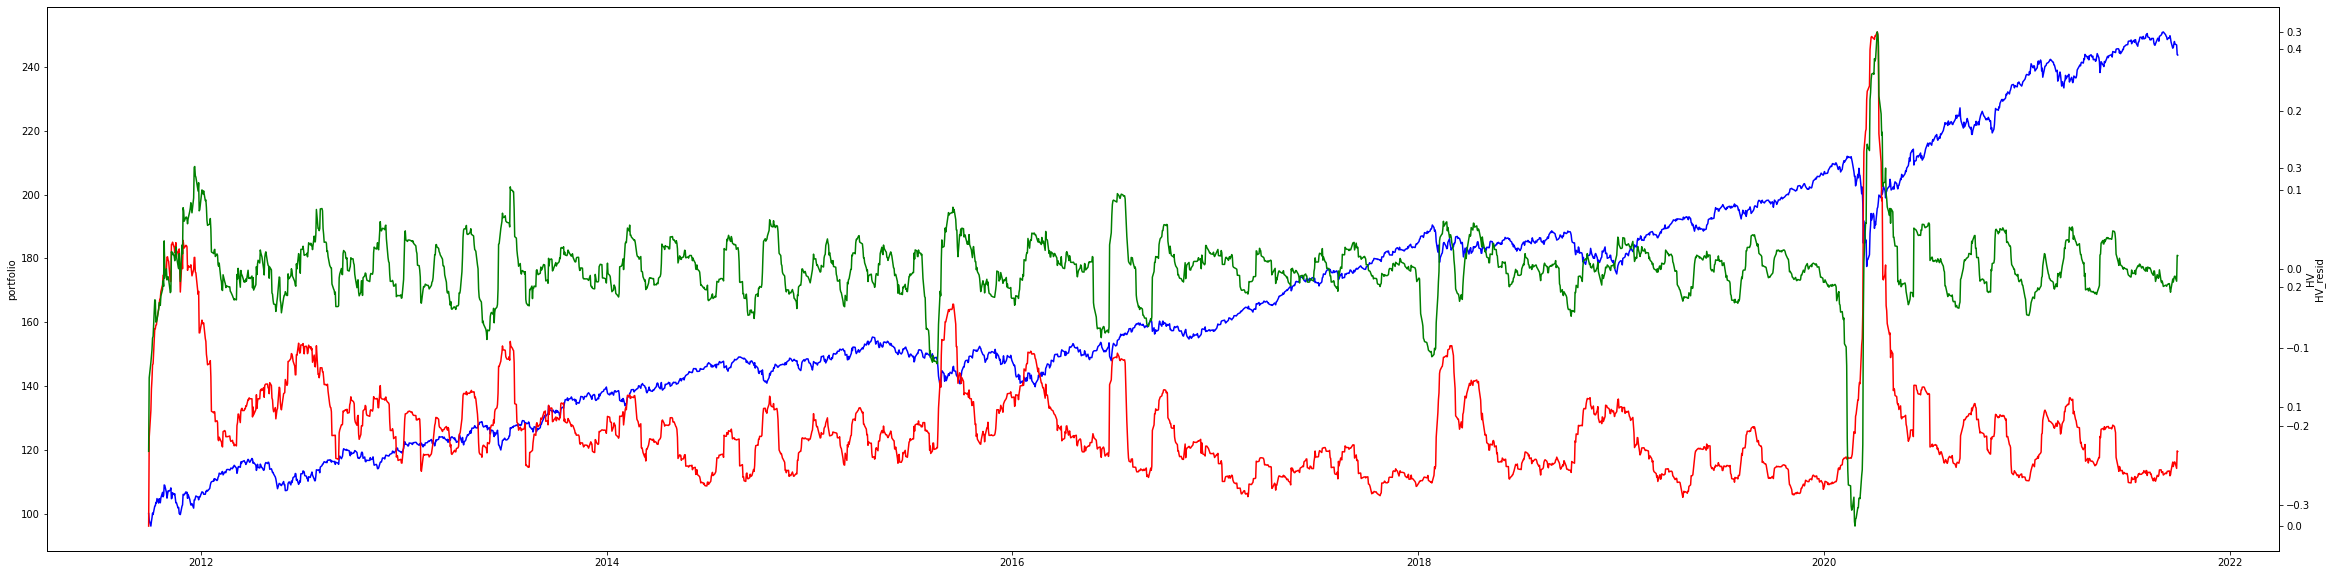

In [38]:
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

sns.lineplot(ax=ax1, color='b', y=bench_def_hv['portfolio'], x=bench_def_hv.index)
sns.lineplot(ax=ax2, color='r', y=bench_def_hv['HV'], x=bench_def_hv.index)
sns.lineplot(ax=ax3, color='g', y=bench_def_hv['HV_resid'], x=bench_def_hv.index)

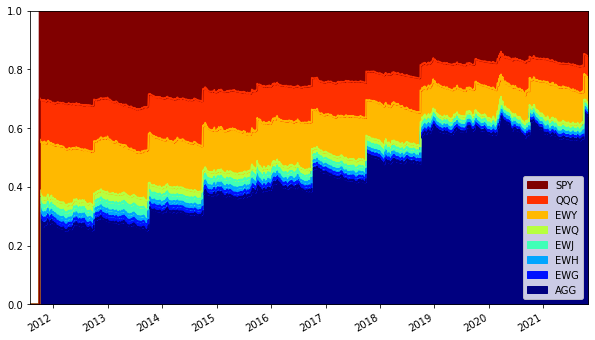

In [39]:
ax = bench_def_result.get_security_weights().plot.area(figsize = (10, 6), ylim = [0, 1], legend = False, colormap = cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')
plt.show()

# 공격/중립/방어형 비교

<AxesSubplot:ylabel='HV'>

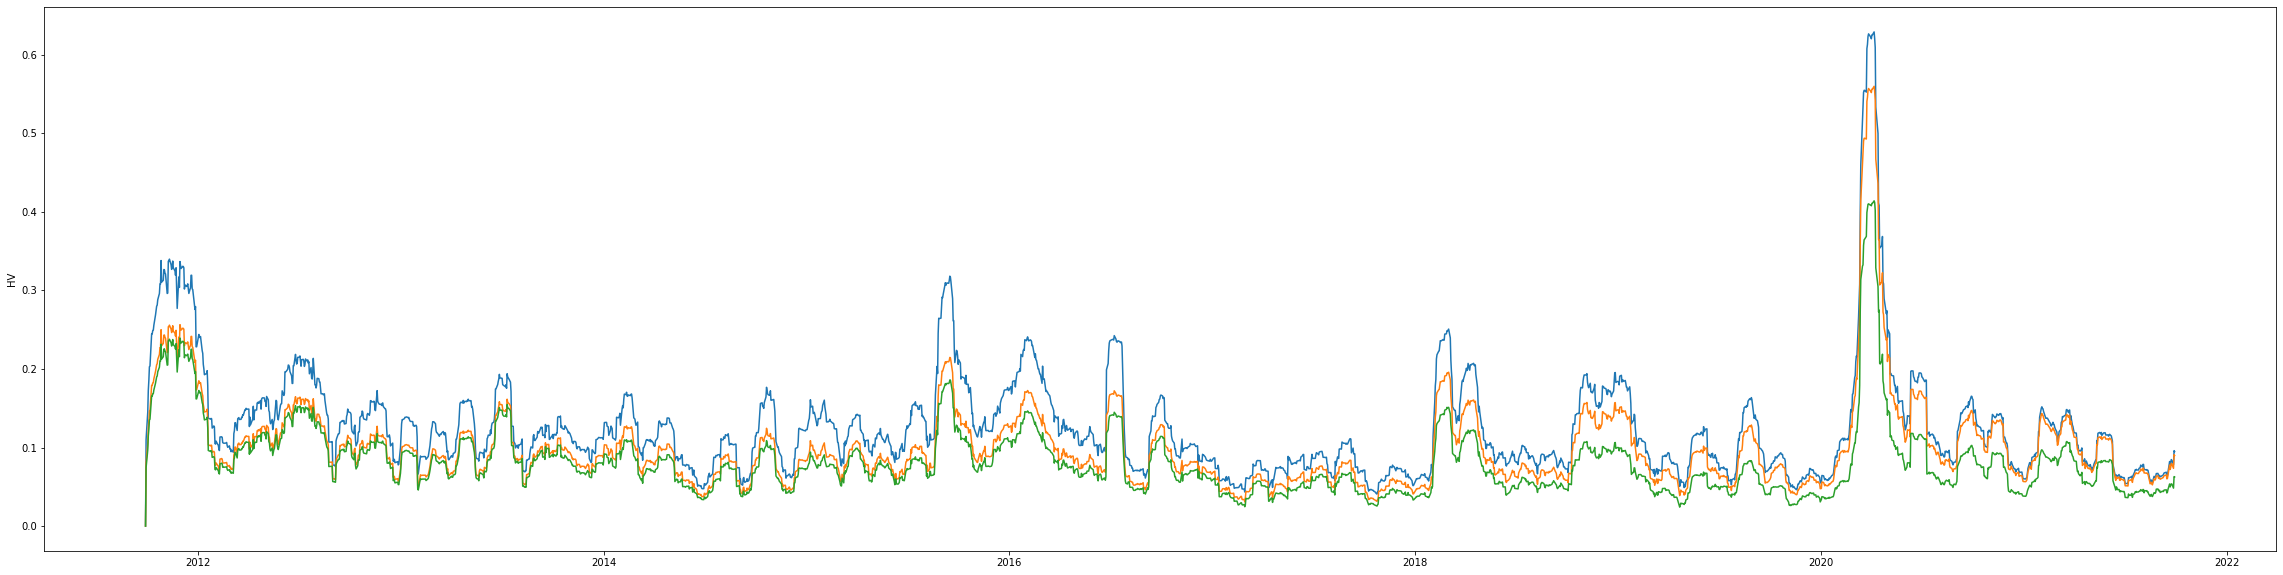

In [40]:
fig, ax1 = plt.subplots(figsize=(40, 10))

sns.lineplot(y=bench_att_hv.loc['2011-09-29':, 'HV'], x=bench_att_hv.loc['2011-09-29':].index)
sns.lineplot(y=bench_neu_hv.loc['2011-09-29':, 'HV'], x=bench_neu_hv.loc['2011-09-29':].index)
sns.lineplot(y=bench_def_hv.loc['2011-09-29':, 'HV'], x=bench_def_hv.loc['2011-09-29':].index)

<AxesSubplot:ylabel='portfolio'>

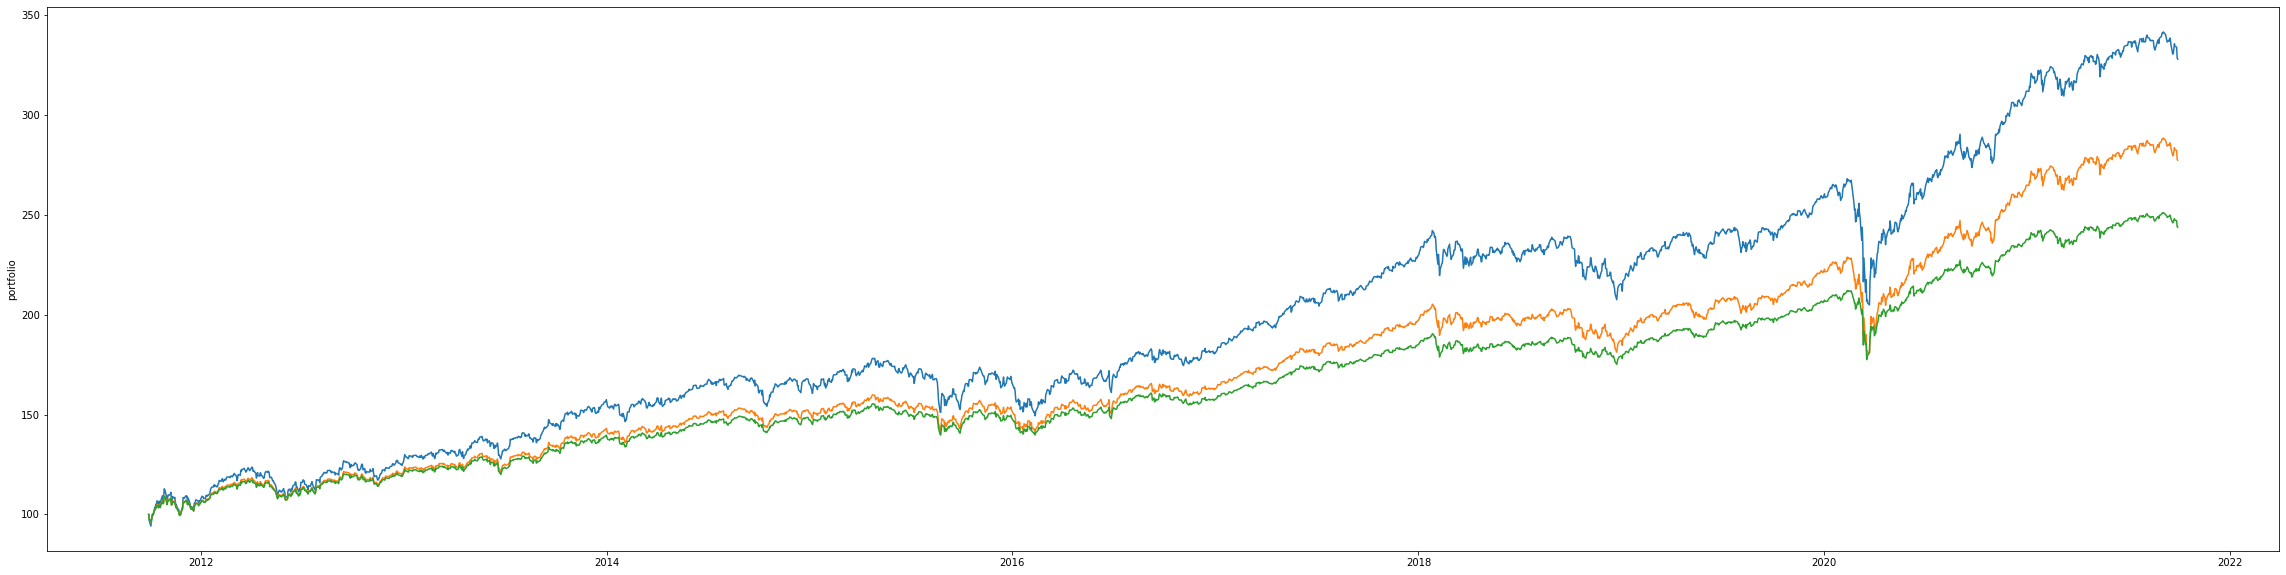

In [41]:
fig, ax1 = plt.subplots(figsize=(40, 10))

sns.lineplot(y=bench_att_hv.loc['2011-09-29':, 'portfolio'], x=bench_att_hv.loc['2011-09-29':].index)
sns.lineplot(y=bench_neu_hv.loc['2011-09-29':, 'portfolio'], x=bench_neu_hv.loc['2011-09-29':].index)
sns.lineplot(y=bench_def_hv.loc['2011-09-29':, 'portfolio'], x=bench_def_hv.loc['2011-09-29':].index)

<AxesSubplot:ylabel='HV_resid'>

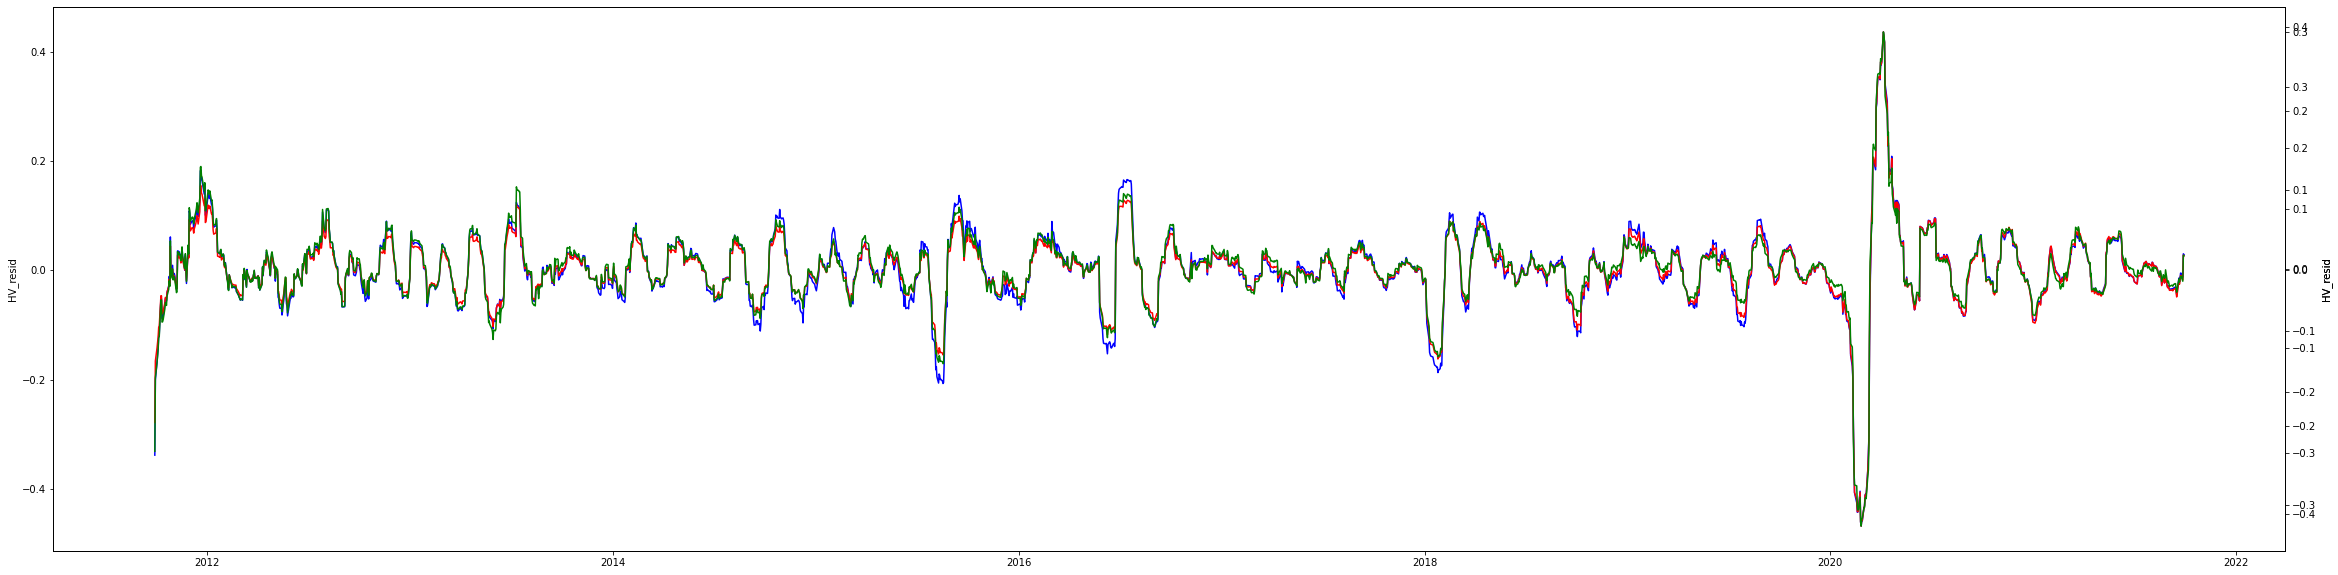

In [42]:
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

sns.lineplot(ax=ax1, color='b', y=bench_att_hv['HV_resid'], x=bench_att_hv.index)
sns.lineplot(ax=ax2, color='r', y=bench_neu_hv['HV_resid'], x=bench_att_hv.index)
sns.lineplot(ax=ax3, color='g', y=bench_def_hv['HV_resid'], x=bench_att_hv.index)

# 글라이드 패스 리밸런싱 함수

In [43]:
bench_att_hv

,portfolio,HV,HV_pred,HV_resid
2011-09-29,100.000000,0.000000,0.338044,-0.338044
2011-09-30,96.894452,0.110236,0.310554,-0.200318
2011-10-03,94.167319,0.144824,0.312931,-0.168107
2011-10-04,96.395740,0.172882,0.326629,-0.153747
2011-10-05,98.063515,0.185675,0.326261,-0.140586
...,...,...,...,...
2021-09-23,335.484593,0.084662,0.089858,-0.005196
2021-09-24,334.226522,0.083768,0.089071,-0.005303
2021-09-27,333.807661,0.078138,0.090623,-0.012484
2021-09-28,328.225329,0.096012,0.065917,0.030094


In [44]:
def makeThreshold(a, b, c, d):
    if a > b + c * d:
        result = 1
    else:
        result = 0
    return result

def getRebalanceDates(a, b):
    if (a == 1) & (b != 1):
        result = 'out'
    elif (a != 1) & (b == 1):
        result = 'in'
    else:
        result = np.nan
    return result

def getOutSignal(a, b):
    if a <= b:
        result = 1
    else:
        result = 0
    return result

def getOutDate(a, b):
    if (a == 1) & (b ==0):
        result = 1
    else:
        result = 0
    return result

def getRebalancedGlidePath(
    hv, glide_path, 
    std_multiple, 
    period, 
    k, 
    # rb_period, tol
):
    
    df = hv.copy()
    gp = glide_path.copy()
    gp['class'] = 'gp'
    
    df['HV_resid_signal'] = -0.0016597886929884428 - std_multiple * (0.08312857254567534)
    
    # df['class'] = np.where(df['HV'] > HV_resid_signal, 1, 0)
    df['Out_signal'] = df.apply(lambda x: getOutSignal(x['HV_resid'], x['HV_resid_signal']), axis=1)
    df['Out_signal_shift'] = df['Out_signal'].shift(1)
    df['Out_date'] = df.apply(lambda x: getOutDate(x['Out_signal'], x['Out_signal_shift']), axis=1)
    
    df.reset_index(inplace=True)
    out_idx = df[df['Out_date'] == 1].index
    
    rb_idx  = []
    in_idx  = []
    for out_date_idx in out_idx:
        idx = out_date_idx
        while df.iloc[idx, 4] <= (-0.0016597886929884428 + 0.3 * (0.08312857254567534)):
            rb_idx.append(idx)
            idx = idx + 1
        in_idx.append(idx)
    
    df['In_date'] = 0
    df.iloc[in_idx, -1] = 1
    
    df['RB'] = 0
    df.iloc[rb_idx, -1] = 1
    
    df.set_index('index', inplace=True)
    
    df['class'] = np.nan
    df.iloc[out_idx, -1] = 'out'
    df.iloc[in_idx,  -1] = 'in'
    history = df.copy()
    
    # HV의 평균 모멘텀 스코어(MMS)
    # hv_mms = []
    # for timeperiod in range(20, 260, 20):
    #     hv_mms.append(np.where(talib.MOM(df['HV'], timeperiod=timeperiod) > 0, 1, 0))
    # df['HV_MMS'] = np.mean(np.array(hv_mms), axis=0)
    # df['HV_MMS_shift'] = df['HV_MMS'].shift(1)
    # df['Position'] = np.where(df['HV_MMS'] == 1, 1, 0)
    # df['class'] = df.apply(lambda x: getRebalanceDates(x['HV_MMS'], x['HV_MMS_shift']), axis=1)
    
    # df['Condition'] = df.apply(lambda x: makeThreshold(x['HV'], x['HV_mean'], x['HV_std'], std_multiple), axis=1)
    
    # df['Position'] = 0
    # idx_list = []
    # i = rb_period - 1
    # while i < df.shape[0]:
    #     if df.iloc[i, 5] == 1:
    #         idx_list.append(list(range(i, i + rb_period)))
    #         i = i + tol
    #     i = i + 1
    # idx_list = np.array(idx_list).reshape(-1)
    # df.iloc[idx_list, -1] = 1
    
    # 위험자산 비중 축소일, 복귀일
    
    
    if period == 1:
        gp = gp[:'2016-09-29']
        df = df[:'2016-09-29']
        df = df[df['class'].notna()]
    elif period == 2:
        gp = gp
        df = df['2016-09-29':]
        df = df[df['class'].notna()]
        if df.iloc[0, -1] == 'in':
            df = df[1:]
    else:
        print('error')
    
    # 기존 글라이드 패스에 리밸런싱 일자 추가
    gp = pd.concat([gp, df[df['class'].notna()][['class']]], axis=0).sort_index()
    gp.reset_index(inplace=True)
    
    i = 0
    drop_cnt = 0
    while i < gp.shape[0] + drop_cnt:
        if gp.loc[i, 'class'] == 'out':
            gp.loc[i, 'EWG'] = (1 - k) * gp.loc[i - 1, 'EWG']
            gp.loc[i, 'EWH'] = (1 - k) * gp.loc[i - 1, 'EWH']
            gp.loc[i, 'EWJ'] = (1 - k) * gp.loc[i - 1, 'EWJ']
            gp.loc[i, 'EWQ'] = (1 - k) * gp.loc[i - 1, 'EWQ']
            gp.loc[i, 'EWY'] = (1 - k) * gp.loc[i - 1, 'EWY']
            gp.loc[i, 'QQQ'] = (1 - k) * gp.loc[i - 1, 'QQQ']
            gp.loc[i, 'SPY'] = (1 - k) * gp.loc[i - 1, 'SPY']
            gp.loc[i, 'AGG'] = 1 - gp.loc[i, 'EWG':'SPY'].sum()
        elif gp.loc[i, 'class'] == 'in':
            if gp.loc[i - 1, 'class'] == 'gp':
                gp.loc[i, 'EWG'] = gp.loc[i - 1, 'EWG']
                gp.loc[i, 'EWH'] = gp.loc[i - 1, 'EWH']
                gp.loc[i, 'EWJ'] = gp.loc[i - 1, 'EWJ']
                gp.loc[i, 'EWQ'] = gp.loc[i - 1, 'EWQ']
                gp.loc[i, 'EWY'] = gp.loc[i - 1, 'EWY']
                gp.loc[i, 'QQQ'] = gp.loc[i - 1, 'QQQ']
                gp.loc[i, 'SPY'] = gp.loc[i - 1, 'SPY']
                gp.loc[i, 'AGG'] = gp.loc[i - 1, 'AGG']
                gp.drop(axis=0, index=[i - 1], inplace=True)
                drop_cnt = drop_cnt + 1
            elif gp.loc[i - 1, 'class'] == 'out':
                gp.loc[i, 'EWG'] = gp.loc[i - 2, 'EWG']
                gp.loc[i, 'EWH'] = gp.loc[i - 2, 'EWH']
                gp.loc[i, 'EWJ'] = gp.loc[i - 2, 'EWJ']
                gp.loc[i, 'EWQ'] = gp.loc[i - 2, 'EWQ']
                gp.loc[i, 'EWY'] = gp.loc[i - 2, 'EWY']
                gp.loc[i, 'QQQ'] = gp.loc[i - 2, 'QQQ']
                gp.loc[i, 'SPY'] = gp.loc[i - 2, 'SPY']
                gp.loc[i, 'AGG'] = gp.loc[i - 2, 'AGG']
        elif gp.loc[i, 'class'] == 'gp':
            pass
        i = i + 1
    
    gp.set_index('index', inplace=True)
    
    return gp, history

# 1기간 리밸런싱 GP & PF

## 공격형

In [50]:
bench_att_hv

,portfolio,HV,HV_pred,HV_resid
2011-09-29,100.000000,0.000000,0.338044,-0.338044
2011-09-30,96.894452,0.110236,0.310554,-0.200318
2011-10-03,94.167319,0.144824,0.312931,-0.168107
2011-10-04,96.395740,0.172882,0.326629,-0.153747
2011-10-05,98.063515,0.185675,0.326261,-0.140586
...,...,...,...,...
2021-09-23,335.484593,0.084662,0.089858,-0.005196
2021-09-24,334.226522,0.083768,0.089071,-0.005303
2021-09-27,333.807661,0.078138,0.090623,-0.012484
2021-09-28,328.225329,0.096012,0.065917,0.030094


<AxesSubplot:xlabel='index', ylabel='RB'>

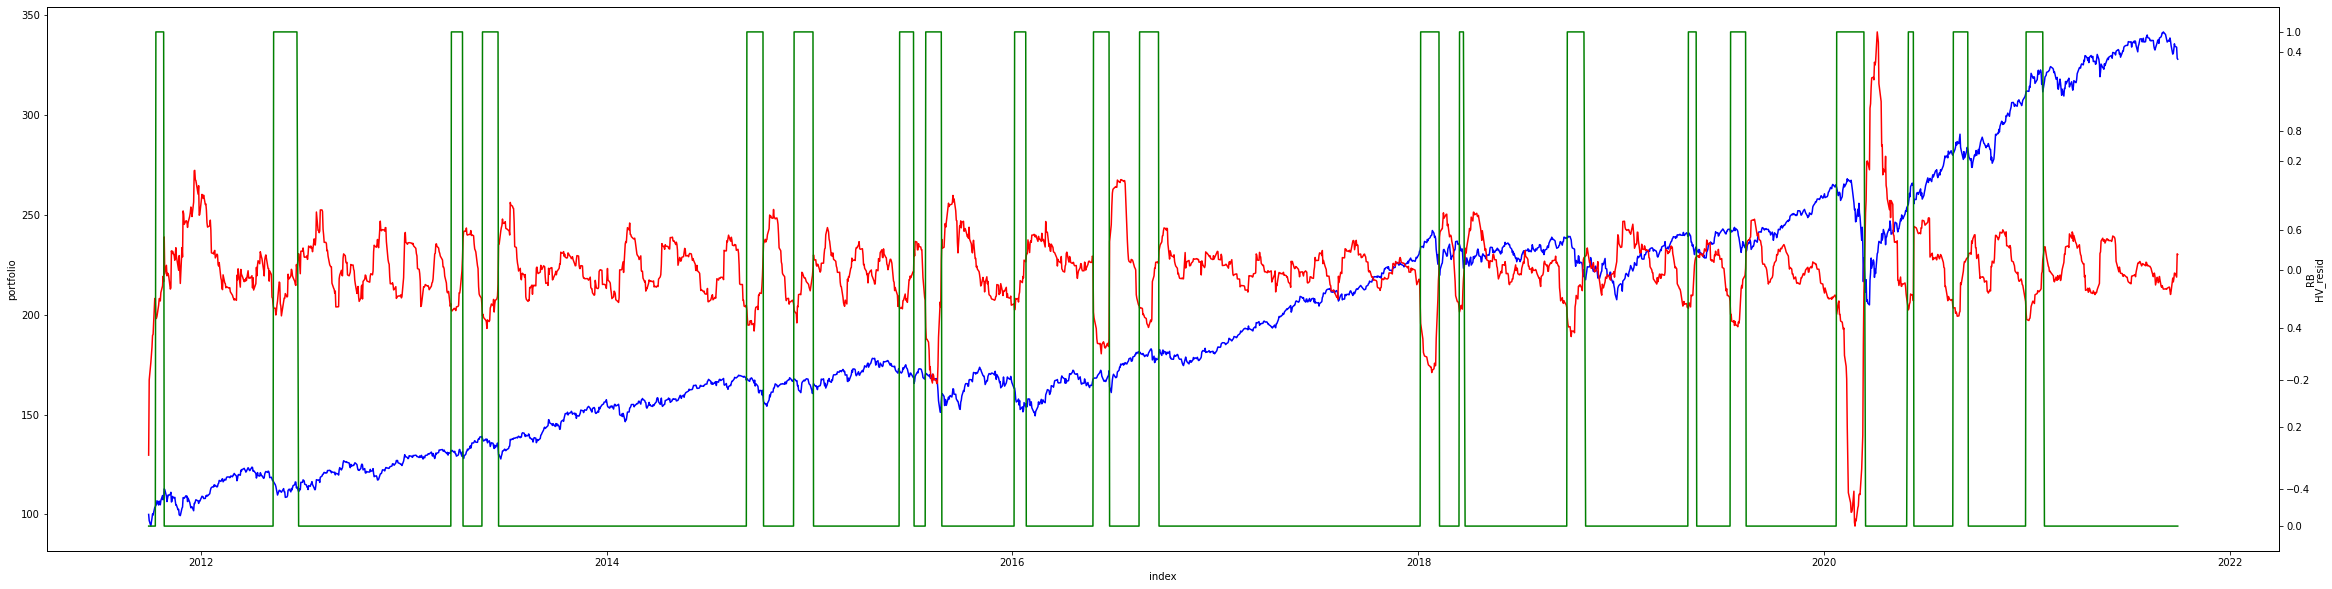

In [45]:
gp_first_att, history_first_att = getRebalancedGlidePath(
    bench_att_hv, gp_bench_att, 
    std_multiple=0.80, 
    period=1, 
    k=.4, 
    # std_multiple_in=3, k=.4, rb_period=20, tol=200
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

start = '2011-09-29'
end   = '2021-09-29'

sns.lineplot(ax=ax1, color='b', y=history_first_att[start:end]['portfolio'], x=history_first_att[start:end].index)
sns.lineplot(ax=ax2, color='r', y=history_first_att[start:end]['HV_resid'], x=history_first_att[start:end].index)
sns.lineplot(ax=ax3, color='g', y=history_first_att[start:end]['RB'], x=history_first_att[start:end].index)

<AxesSubplot:>

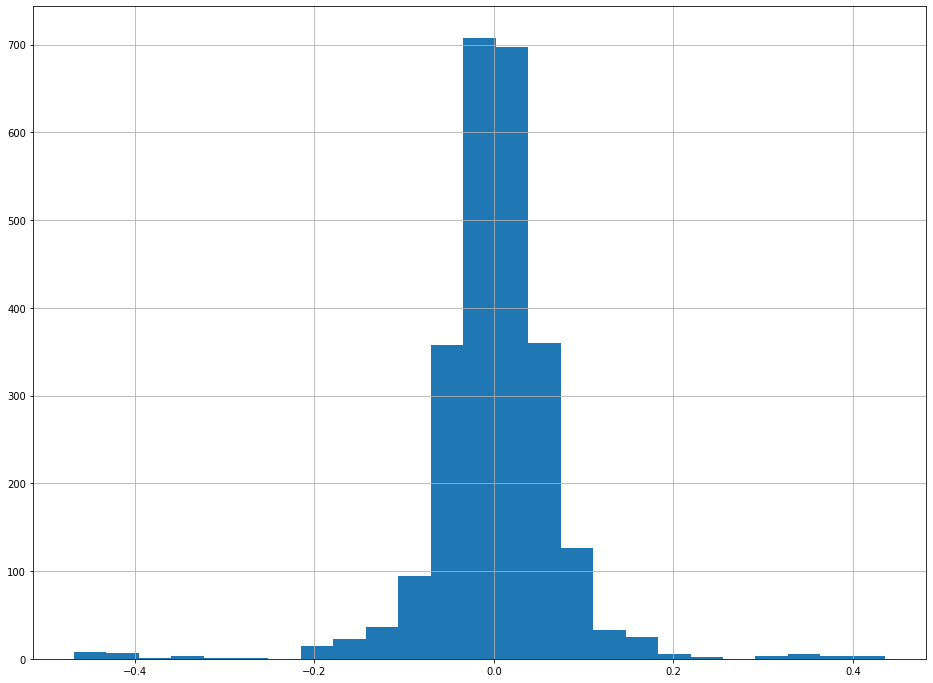

In [46]:
history_first_att[start:end]['HV_resid'].hist(bins=25, figsize=(16, 12))

In [47]:
data = etf['Adj Close'].loc['2011-07-29':]

first_att = bt.Strategy(
    'portfolio', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_first_att.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)
first_att_backtest = bt.Backtest(strategy=first_att, data=data)
first_att_result   = bt.run(first_att_backtest)

first_att_hv = first_att_result.prices
first_att_hv['HV'] = first_att_hv['portfolio'].pct_change().rolling(window=20, min_periods=0, center=False).std() * np.sqrt(252)
first_att_hv = first_att_hv['2011-09-29':'2016-09-29']
first_att_hv

,portfolio,HV
2011-09-29,100.000000,0.000000
2011-09-30,96.894452,0.110236
2011-10-03,94.167319,0.144824
2011-10-04,96.395740,0.172882
2011-10-05,98.063515,0.185675
...,...,...
2016-09-23,201.362928,0.105719
2016-09-26,199.594399,0.109907
2016-09-27,201.653691,0.115206
2016-09-28,202.561990,0.116101


In [48]:
bench_att_hv['2011-09-29':'2016-09-29']

,portfolio,HV,HV_pred,HV_resid
2011-09-29,100.000000,0.000000,0.338044,-0.338044
2011-09-30,96.894452,0.110236,0.310554,-0.200318
2011-10-03,94.167319,0.144824,0.312931,-0.168107
2011-10-04,96.395740,0.172882,0.326629,-0.153747
2011-10-05,98.063515,0.185675,0.326261,-0.140586
...,...,...,...,...
2016-09-23,181.157929,0.154897,0.108577,0.046321
2016-09-26,179.555328,0.157569,0.105668,0.051900
2016-09-27,181.465306,0.161161,0.098294,0.062867
2016-09-28,182.282118,0.161665,0.098358,0.063307


In [49]:
temp = history_first_att['2011-09-29':'2016-09-29']

macd, macdsignal, macdhist = talib.MACD(temp['HV'], fastperiod=20, slowperiod=40, signalperiod=10)
temp['MACD'] = macd
temp['MACD_sig9'] = macdsignal
temp['MACD_OSC'] = macdhist


delta = temp['HV'].diff(1)
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

_gain = up.ewm(com=(14 - 1), min_periods=14).mean()
_loss = down.abs().ewm(com=(14 - 1), min_periods=14).mean()

temp['gain'] = _gain
temp['loss'] = _loss

temp['signal'] = temp['HV_mean'] + 2 * temp['HV_std']

%matplotlib inline
fig, ax1 = plt.subplots(figsize=(30, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
ax5 = ax1.twinx()
ax6 = ax1.twinx()

sns.lineplot(x=temp.index, y=temp['HV'], ax=ax1, color='red')
sns.lineplot(x=temp.index, y=temp['portfolio'], ax=ax2)
# sns.lineplot(x=temp.index, y=temp['signal'], ax=ax1, color='green')
sns.lineplot(x=temp.index, y=temp['Position'], ax=ax4, color='purple')
# sns.lineplot(x=temp.index, y=temp['MACD'], ax=ax5, color='black')
# sns.lineplot(x=temp.index, y=temp['MACD_sig9'], ax=ax5, color='orange')
# sns.lineplot(x=temp.index, y=temp['MACD_OSC'], ax=ax6, color='pink')
# sns.lineplot(x=temp.index, y=temp['gain'], ax=ax6, color='pink')
# sns.lineplot(x=temp.index, y=temp['loss'], ax=ax6, color='blue')
plt.show()

C:\Users\674\AppData\Local\Temp/ipykernel_20504/3794093568.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['MACD'] = macd
C:\Users\674\AppData\Local\Temp/ipykernel_20504/3794093568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['MACD_sig9'] = macdsignal
C:\Users\674\AppData\Local\Temp/ipykernel_20504/3794093568.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

KeyError: 'HV_mean'

In [ ]:
df = pd.read_csv('./test.csv', sep='\t')

In [ ]:
df

In [ ]:
df.iloc[:, 1:].plot(figsize=(20, 10))

## 중립형

In [ ]:
gp_first_neu, history_first_new = getRebalancedGlidePath(bench_neu_hv, gp_bench_neu, std_multiple_out=2, k=.25, period=1, rb_period=1, tol=30)

In [ ]:
data = etf['Adj Close'].loc['2011-07-29':]

first_neu = bt.Strategy(
    'portfolio', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_first_neu.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)
first_neu_backtest = bt.Backtest(strategy=first_neu, data=data)
first_neu_result   = bt.run(first_neu_backtest)

first_neu_hv = first_neu_result.prices
first_neu_hv['HV'] = first_neu_hv['portfolio'].pct_change().rolling(window=20, min_periods=0, center=False).std() * np.sqrt(252)
first_neu_hv = first_neu_hv['2011-09-29':'2016-09-29']
first_neu_hv

In [ ]:
bench_neu_hv[:'2016-09-29']

## 방어형

# 2기간 리밸런싱 GP & PF

## 공격형

In [ ]:
# gp_second_att, history_second_att = getRebalancedGlidePath(
#     bench_att_hv, gp_bench_att, 
#     std_multiple_out=2, 
#     k=.4, period=2, tollerance=20
# )

gp_second_att, history_second_att = getRebalancedGlidePath(
    bench_att_hv, gp_bench_att, 
    std_multiple=0.80, 
    period=1, 
    k=.4, 
    # std_multiple_in=3, k=.4, rb_period=20, tol=200
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

start = '2011-09-29'
end   = '2021-09-29'

sns.lineplot(ax=ax1, color='b', y=history_second_att[start:end]['portfolio'], x=history_second_att[start:end].index)
sns.lineplot(ax=ax2, color='r', y=history_second_att[start:end]['HV_resid'], x=history_second_att[start:end].index)
sns.lineplot(ax=ax3, color='g', y=history_second_att[start:end]['RB'], x=history_second_att[start:end].index)

In [ ]:
data = etf['Adj Close'].loc['2011-07-29':]

second_att = bt.Strategy(
    'portfolio', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_second_att.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)
second_att_backtest = bt.Backtest(strategy=second_att, data=data)
second_att_result   = bt.run(second_att_backtest)

second_att_hv = second_att_result.prices
second_att_hv['HV'] = second_att_hv['portfolio'].pct_change().rolling(window=20, min_periods=0, center=False).std() * np.sqrt(252)
second_att_hv = second_att_hv['2011-09-29':'2021-09-29']
second_att_hv

In [ ]:
bench_att_hv

In [ ]:
data = etf['Adj Close'].loc['2011-07-29':]

second_att = bt.Strategy(
    'portfolio', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_second_att.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)
second_att_backtest = bt.Backtest(strategy=second_att, data=data)
second_att_result   = bt.run(second_att_backtest)

second_att_hv = second_att_result.prices
second_att_hv['HV'] = second_att_hv['portfolio'].pct_change().rolling(window=20, min_periods=0, center=False).std() * np.sqrt(252)
second_att_hv = second_att_hv['2011-09-29':]
second_att_hv

In [ ]:
df, gp= getRebalancedGlidePath(bench_att_hv, gp_bench_att, std_multiple=4, k=.4, period=2)
df

In [ ]:
gp

In [ ]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(30, 10))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

sns.lineplot(x=df.index, y=df['HV'], ax=ax1, color='red')
sns.lineplot(x=df.index, y=df['portfolio'], ax=ax2)
sns.lineplot(x=df.index, y=df['Position'], ax=ax3, color='green')
plt.show()

# df[['bench_att', 'HV', 'Position']].plot(figsize=(30, 10))

# 2기간 리밸런싱

# BT 시각화

## backtest result

In [ ]:
result.display()

In [ ]:
result.stats

## total return

In [ ]:
result.prices

## MDD

In [ ]:
result.prices

In [ ]:
import pyfolio as pf

In [ ]:
%matplotlib inline
a = result.prices.to_drawdown_series()
a.plot(figsize=(30, 5))

In [ ]:
result.prices.to_returns().fillna(method='bfill')['benchmark_portfolio']

In [ ]:
b = result.prices.to_returns().fillna(method='bfill')['benchmark_portfolio']

In [ ]:
type(b)

In [ ]:
pf.create_full_tear_sheet(b)

In [ ]:
pf.plot_annual_returns(b)

In [ ]:
pf.plot_daily_volume(b)

In [ ]:
%matplotlib inline
result.plot()

## transactions

In [ ]:
result.get_transactions()

## montly returns

In [ ]:
result.display_monthly_returns()

## daily weights

In [ ]:
result.get_weights()

In [ ]:
result.plot_security_weights()

In [ ]:
result.plot_weights()

In [ ]:
from matplotlib import cm

ax = result.get_security_weights().plot.area(figsize = (10, 6), ylim = [0, 1], legend = False, colormap = cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')
plt.show()

## daily returns

In [ ]:
result.display_lookback_returns()

In [ ]:
result.prices.to_returns()

In [ ]:
result.prices.to_returns().plot(figsize=(30, 10))

In [ ]:
result.plot_histogram()

In [ ]:
result.plot_histograms()